# Air Quality Prediction Experiment

This notebook combines PWWB, AirNow, and HRRR datasets for air quality prediction using PyTorch.

# Experiment Configuration

In [2]:
# ========== EXPERIMENT CONFIGURATION ==========
# Change these variables to configure your experiment

EXPERIMENT_NAME = "January 2022 to December 2024"
EXPERIMENT_DESCRIPTION = "January 2025 fire period with PWWB, Airnow, and HRRR data."
EXPERIMENT_ID = "two_years_pwwb_airnow_hrrr"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"
TRAIN_SPLIT = 0.80  # 70% for training, 10% for val (will split later), leaving 20% for test.

# Model parameters
EPOCHS = 500
BATCH_SIZE = 16
WEIGHT_DECAY = 0.01

print(f"Experiment: {EXPERIMENT_NAME}")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date Range: {START_DATE} to {END_DATE}")
print(f"Train/Test Split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}% (temporal)")

Experiment: January 2022 to December 2024
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date Range: 2022-12-01-00 to 2024-12-01-00
Train/Test Split: 80%/20% (temporal)


# Data Parameters

In [3]:
# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


# PyTorch Setup and Dependencies

In [4]:
# Install PyTorch with RTX 5080 support
# Run this in terminal first:
# pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# pip install git+https://github.com/ndrplz/ConvLSTM_pytorch.git

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

# Check RTX 5080 compatibility
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")
    device = torch.device('cuda')
else:
    print("CUDA not available, using CPU")
    device = torch.device('cpu')

# Import ConvLSTM
try:
    from convlstm import ConvLSTM
    print("ConvLSTM imported successfully")
except ImportError:
    print("ConvLSTM not found. Install with: pip install git+https://github.com/ndrplz/ConvLSTM_pytorch.git")

PyTorch version: 2.8.0.dev20250526+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 5080
CUDA version: 12.8
ConvLSTM imported successfully


# Data Ingestion and Preprocessing

In [5]:
# Python nonsense that allows you to import from sibling directories
import sys
sys.path.append("..")

import pandas as pd
from dotenv import load_dotenv

# Import the new PWWB implementation and dataset manager
from libs.pwwb import PWWBData
from libs.pwwb.utils.dataset_manager import create_dataset_manager

# Import the AirNow data class
from libs.airnowdata import AirNowData

# Import the HRRR data class
from libs.hrrrdata import HRRRData

# Load environment variables (API keys, credentials)
load_dotenv()

# Temporal train-test split function
def temporal_train_test_split(X, Y, train_size=TRAIN_SPLIT):
    """Split data temporally - first portion for training, last portion for testing"""
    split_idx = int(X.shape[0] * train_size)
    
    X_train = X[:split_idx]
    X_test = X[split_idx:]
    Y_train = Y[:split_idx]
    Y_test = Y[split_idx:]
    
    print(f"Temporal split at index {split_idx}:")
    print(f"  Training: samples 0-{split_idx-1} ({train_size*100:.0f}% of time)")
    print(f"  Testing: samples {split_idx}-{len(X)-1} ({(1-train_size)*100:.0f}% of time)")
    
    return X_train, X_test, Y_train, Y_test

# Per-channel standardization function
from sklearn.preprocessing import StandardScaler

def std_scale(X_train, X_test):
    """
    Standardize each channel independently to preserve relative relationships
    within each data type while ensuring fair comparison across experiments.
    """
    X_train_scaled = X_train.copy().astype(np.float32)
    X_test_scaled = X_test.copy().astype(np.float32)
    
    n_channels = X_train.shape[-1]
    
    # Standardize each channel independently
    for c in range(n_channels):
        print(f"  Standardizing channel {c}...")
        
        scaler = StandardScaler()
        
        # Flatten spatial/temporal dims but keep channels separate
        train_channel = X_train[:,:,:,:,c].reshape(-1, 1)
        test_channel = X_test[:,:,:,:,c].reshape(-1, 1)
        
        # Fit scaler on training data only
        train_scaled = scaler.fit_transform(train_channel)
        test_scaled = scaler.transform(test_channel)
        
        # Reshape back to original dimensions
        X_train_scaled[:,:,:,:,c] = train_scaled.reshape(X_train[:,:,:,:,c].shape)
        X_test_scaled[:,:,:,:,c] = test_scaled.reshape(X_test[:,:,:,:,c].shape)
        
        print(f"    Channel {c}: mean={scaler.mean_[0]:.6f}, std={scaler.scale_[0]:.6f}")
    
    return X_train_scaled, X_test_scaled

/home/moh/miniconda3/envs/hysplitrevised/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Create output directory for results
output_dir = f"experiment_output/{EXPERIMENT_ID}"
os.makedirs(output_dir, exist_ok=True)

# Create dataset manager
manager = create_dataset_manager(
    registry_file=f"{EXPERIMENT_ID}_registry.json",
    cache_dir="data/pwwb_cache/"
)

# List existing datasets
print("Existing datasets:")
try:
    display(manager.list_datasets())
except:
    print("No existing datasets found.")

Existing datasets:


,name,created,description,start_date,end_date,channels
0,two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_M...,2025-05-30T15:44:54.156124,"January 2025 fire period with PWWB, Airnow, an...",2022-12-01-00,2024-12-01-00,"maiac, tropomi, metar"


In [7]:
# Adjust end date for AirNow
end_date_adj = pd.to_datetime(END_DATE) - pd.Timedelta(hours=1)

# Dataset name and description
dataset_name = f"{EXPERIMENT_ID}_MAIAC_TROPOMI_NO2_METAR_WIND_UV"
dataset_desc = f"{EXPERIMENT_DESCRIPTION} - MAIAC, TROPOMI NO2, METAR Wind U/V components"

# ========== 1. Load PWWB Data ==========
print(f"\nLoading PWWB data for {EXPERIMENT_NAME}...")

# Check if dataset already exists in the registry
if manager.get_dataset_info(dataset_name) is not None:
    print(f"Dataset '{dataset_name}' already exists, loading from cache...")
    pwwb_data = manager.load_dataset(dataset_name, PWWBData)
else:
    print(f"Dataset '{dataset_name}' not found, creating new one...")
    # Create the dataset with the specified channels
    pwwb_data = manager.create_dataset(
        name=dataset_name,
        description=dataset_desc,
        PWWBData_class=PWWBData,
        start_date=START_DATE,
        end_date=END_DATE,
        extent=extent,
        frames_per_sample=frames_per_sample,
        dim=dim,
        include_channels={
            'maiac': True,                     # Include MAIAC AOD
            'tropomi': ['TROPOMI_NO2'],        # Only include NO2 from TROPOMI
            'metar': ['METAR_Wind_U', 'METAR_Wind_V'],  # Only wind components from METAR
            'modis_fire': False,               # Exclude MODIS fire data
            'merra2': False                    # Exclude MERRA2 data
        },
        verbose=True,
        output_dir=output_dir
    )
    # Save the dataset
    pwwb_data.save_data()

# Get the data and channel info
X_pwwb = pwwb_data.data
channel_info = pwwb_data.get_channel_info()
print(f"✓ PWWB data shape: {X_pwwb.shape}")
print(f"  Channels: {channel_info['channel_names']}")
LA_SENSORS = [
    "Santa Clarita",
    "Simi Valley - Cochran Street",
    "Reseda", 
    "North Hollywood",
    "North Holywood",
    "Glendora - Laurel",
    "Los Angeles - N. Main Street",
    "Compton",
    "Long Beach Signal Hill"
]
# ========== 2. Load AirNow Data ==========
print(f"\nLoading AirNow data for {EXPERIMENT_NAME}...")
airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=end_date_adj,
    extent=extent,
    airnow_api_key=os.getenv('AIRNOW_API_KEY'),
    frames_per_sample=frames_per_sample,
    dim=dim,
    sensor_whitelist=LA_SENSORS,
    use_whitelist=True,
    elevation_path="../libs/inputs/elevation.npy",
    mask_path="../libs/inputs/mask.npy",
    use_mask=False,
    force_reprocess=False
)
X_airnow = airnow_data.data
Y_targets = airnow_data.target_stations
print(f"✓ AirNow data shape: {X_airnow.shape}")
if Y_targets is not None:
    print(f"  Target stations shape: {Y_targets.shape}")
    print(f"  Number of sensors: {len(airnow_data.air_sens_loc)}")
else:
    print("  No target stations available")
# ========== 3. Load HRRR Data ==========
print(f"\nLoading HRRR data for {EXPERIMENT_NAME}...")
hrrr_data = HRRRData(
    start_date=START_DATE,
    end_date=END_DATE,
    extent=extent,
    extent_name='la_region',
    product='COLMD',
    frames_per_sample=frames_per_sample,
    dim=dim,
    verbose=True,
    sample_setting=2
)
X_hrrr = hrrr_data.data
print(f"✓ HRRR data shape: {X_hrrr.shape}")


Loading PWWB data for January 2022 to December 2024...
Dataset 'two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV' already exists, loading from cache...
Using cache prefix: two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_
Initialized PWWBData with 17544 hourly timestamps
Date range: 2022-12-01 00:00:00 to 2024-11-30 23:00:00
Channels included: ['maiac', 'tropomi', 'metar']
TROPOMI channels: ['TROPOMI_NO2']
METAR channels: ['METAR_Wind_U', 'METAR_Wind_V']
Processing MAIAC AOD data...
Loading cached data from data/pwwb_cache/two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_maiac_aod_data.npy
Processing TROPOMI data...
Including TROPOMI channels: ['TROPOMI_NO2']
Loading cached data from data/pwwb_cache/two_years_pwwb_airnow_hrrr_MAIAC_TROPOMI_NO2_METAR_WIND_UV_tropomi_no2_data.npy
Processing METAR meteorological data...
Loaded elevation data from inputs/elevation.npy
Elevation range: 0m to 100m
Initialized MetarDataSource with 2 channels: ['METAR_Wind_U', 'M

In [ ]:
# ========== 4. Create Combined Dataset ==========
print(f"\nCreating combined dataset for {EXPERIMENT_NAME}...")

# Combine all data sources
X_combined = np.concatenate([X_pwwb, X_airnow], axis=-1)
print(f"Combined data shape: {X_combined.shape}")

# Display the number of channels from each source
pwwb_channels = X_pwwb.shape[4]
airnow_channels = X_airnow.shape[4]
hrrr_channels = X_hrrr.shape[4]
total_channels = X_combined.shape[4]

print(f"Channel breakdown:")
print(f"  PWWB: {pwwb_channels} channels")
print(f"  AirNow: {airnow_channels} channels")
print(f"  HRRR: {hrrr_channels} channels")
print(f"  Total: {total_channels} channels")

# Create combined channel names
all_channel_names = channel_info['channel_names'] + ["AirNow_PM25"] + ["HRRR_COLMD"]
print(f"  Channel names: {all_channel_names}")


Creating combined dataset for January 2022 to December 2024...
Combined data shape: (17540, 5, 40, 40, 5)
Channel breakdown:
  PWWB: 4 channels
  AirNow: 1 channels
  HRRR: 1 channels
  Total: 5 channels
  Channel names: ['MAIAC_AOD', 'TROPOMI_NO2', 'METAR_Wind_U', 'METAR_Wind_V', 'AirNow_PM25']


In [ ]:
print(f"\nCreating temporal train/test split for {EXPERIMENT_NAME}...")

X_train, X_test, Y_train, Y_test = temporal_train_test_split(
    X_combined, Y_targets, train_size=TRAIN_SPLIT
)

print(f"✓ Train shapes: X={X_train.shape}, Y={Y_train.shape}")
print(f"✓ Test shapes: X={X_test.shape}, Y={Y_test.shape}")


Creating temporal train/test split for January 2022 to December 2024...
Temporal split at index 14032:
  Training: samples 0-14031 (80% of time)
  Testing: samples 14032-17539 (20% of time)
✓ Train shapes: X=(14032, 5, 40, 40, 5), Y=(14032, 8)
✓ Test shapes: X=(3508, 5, 40, 40, 5), Y=(3508, 8)


: 

In [ ]:
# ========== 6. Standardize Data ==========
print(f"\nStandardizing data for {EXPERIMENT_NAME}...")

X_train_scaled, X_test_scaled = std_scale(X_train, X_test)
print(f"✓ Scaled train shape: {X_train_scaled.shape}")
print(f"✓ Scaled test shape: {X_test_scaled.shape}")

print(f"Original Y_train range: {Y_train.min():.2f} to {Y_train.max():.2f}")
print(f"Original Y_train mean: {Y_train.mean():.2f}, std: {Y_train.std():.2f}")

from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler(feature_range=(0, 1))
Y_train_scaled = y_scaler.fit_transform(Y_train)
Y_test_scaled = y_scaler.transform(Y_test)

print(f"Scaled Y_train range: {Y_train_scaled.min():.2f} to {Y_train_scaled.max():.2f}")
print(f"Scaled Y_train mean: {Y_train_scaled.mean():.2f}, std: {Y_train_scaled.std():.2f}")


Standardizing data for January 2022 to December 2024...


In [ ]:
# Debug cell to check channel names and data shapes
print("=== DEBUGGING CHANNEL INFORMATION ===")
print(f"Experiment name: {EXPERIMENT_NAME}")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"Number of channels in data: {X_train_scaled.shape[4]}")
print(f"Number of channel names provided: {len(all_channel_names)}")
print(f"Channel names length matches data channels: {len(all_channel_names) == X_train_scaled.shape[4]}")
print()

print("Channel names provided:")
for i, name in enumerate(all_channel_names):
    print(f"  {i}: {name}")
print()

print("What the visualization function will use:")
n_channels = X_train_scaled.shape[4]
if all_channel_names is None or len(all_channel_names) != n_channels:
    effective_channel_names = [f"Channel {i}" for i in range(n_channels)]
    print("  Using GENERIC channel names (this is the problem!):")
else:
    effective_channel_names = all_channel_names
    print("  Using PROVIDED channel names:")

for i, name in enumerate(effective_channel_names):
    print(f"  {i}: {name}")
print()

print("=== DATA SAMPLE CHECK ===")
# Check what's actually in the first few channels
sample_idx = 42  # Use same sample as visualization
for c in range(min(3, n_channels)):  # Check first 3 channels
    data = X_train_scaled[sample_idx, 0, :, :, c]  # First frame
    print(f"Channel {c} ({effective_channel_names[c] if c < len(effective_channel_names) else 'Unknown'}):")
    print(f"  Min: {data.min():.6f}, Max: {data.max():.6f}, Mean: {data.mean():.6f}")
    print()

=== DEBUGGING CHANNEL INFORMATION ===
Experiment name: January 2022 to December 2024
X_train_scaled shape: (14032, 5, 40, 40, 5)
Number of channels in data: 5
Number of channel names provided: 5
Channel names length matches data channels: True

Channel names provided:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25

What the visualization function will use:
  Using PROVIDED channel names:
  0: MAIAC_AOD
  1: TROPOMI_NO2
  2: METAR_Wind_U
  3: METAR_Wind_V
  4: AirNow_PM25

=== DATA SAMPLE CHECK ===
Channel 0 (MAIAC_AOD):
  Min: -1.082072, Max: 1.538770, Mean: -0.268708

Channel 1 (TROPOMI_NO2):
  Min: -0.564229, Max: 0.134721, Mean: -0.139519

Channel 2 (METAR_Wind_U):
  Min: -2.473276, Max: -2.212808, Mean: -2.315924



# Data Visualization

Visualizing data for January 2022 to December 2024...


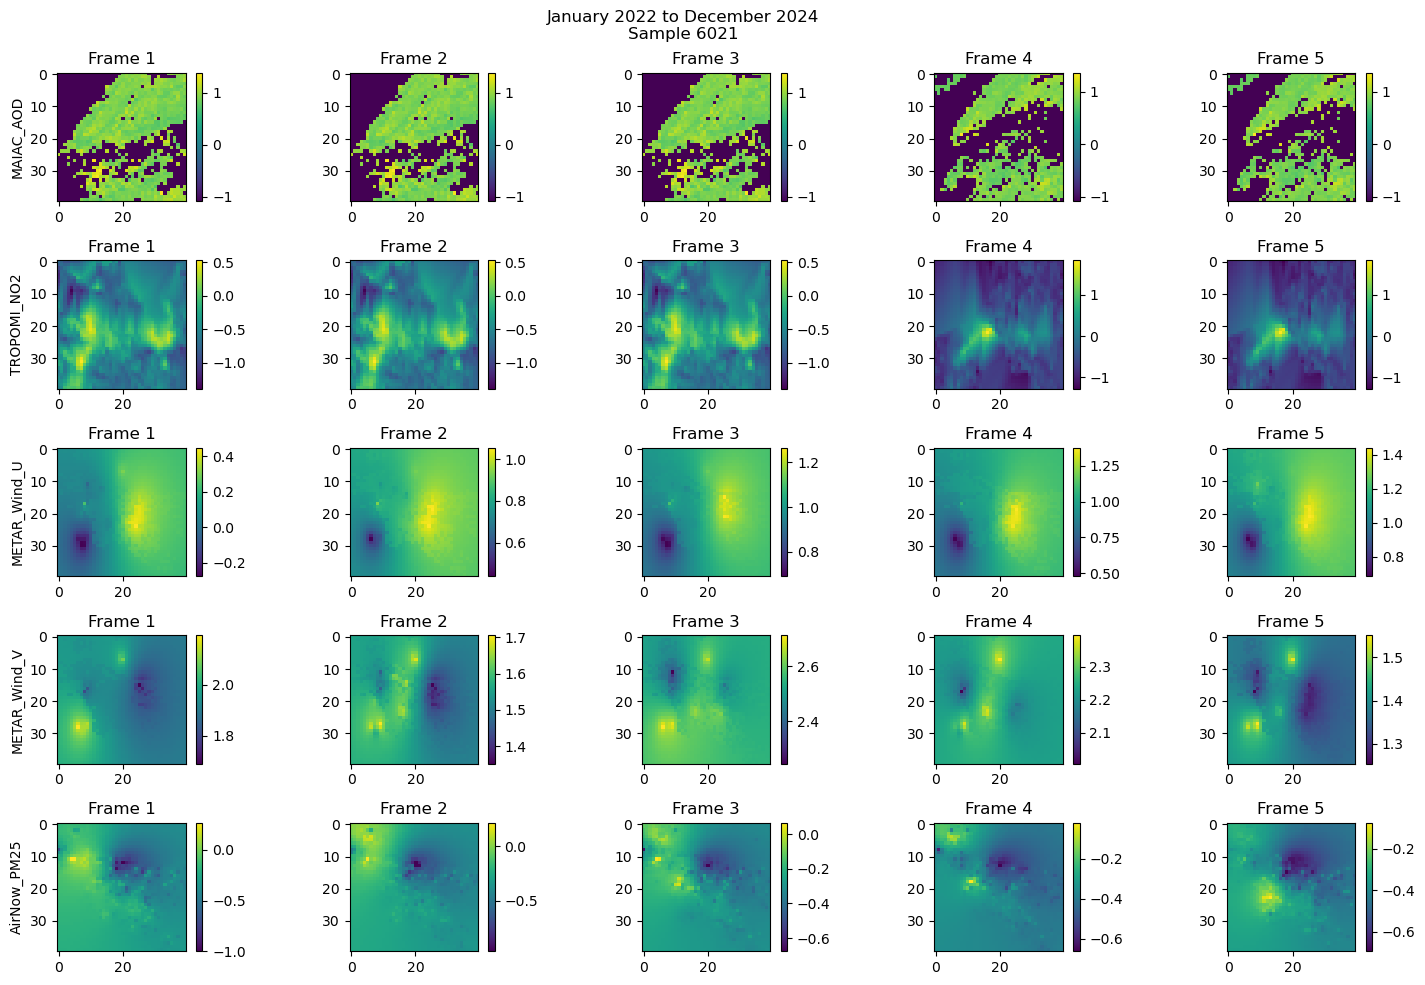

Target values: [ 8.2 10.1  8.2  6.7  8.7 15.4  7.3  4. ]


In [ ]:
# Function to visualize data from experiment
def visualize_experiment_data(X, Y, channel_names=None, sample_idx=None, experiment_name="Experiment"):
    """Visualize data from the experiment"""
    # Get a random sample if none provided
    if sample_idx is None:
        np.random.seed(42)
        sample_idx = np.random.choice(range(len(X)), size=1)[0]
    
    # Get channel information
    n_channels = X.shape[4]
    n_frames = X.shape[1]
    
    # Use provided channel names or create default ones
    if channel_names is None or len(channel_names) != n_channels:
        channel_names = [f"Channel {i}" for i in range(n_channels)]
    
    # Create figure
    fig, axes = plt.subplots(n_channels, n_frames, figsize=(3*n_frames, 2*n_channels))
    if n_channels == 1:
        axes = axes.reshape(1, -1)
    
    # Plot each channel and frame
    for c in range(n_channels):
        channel_name = channel_names[c] if c < len(channel_names) else f"Channel {c}"
        
        for f in range(n_frames):
            ax = axes[c, f]
            data = X[6021, f, :, :, c]
            
            im = ax.imshow(data)
            
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            if f == 0:
                ax.set_ylabel(channel_name)
            ax.set_title(f"Frame {f+1}")
    
    # Set title
    plt.suptitle(f"{experiment_name}\nSample {6021}")
    plt.tight_layout()
    plt.show()
    
    # Print target values
    if Y is not None:
        print(f"Target values: {Y[6021]}")

# Run the visualization  
print(f"Visualizing data for {EXPERIMENT_NAME}...")
visualize_experiment_data(X_train_scaled, Y_train, channel_names=all_channel_names, experiment_name=EXPERIMENT_NAME)

# PyTorch Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from convlstm import ConvLSTM

class PollutantPredictionModel(nn.Module):
    def __init__(self, input_shape, output_size):
        """
        PyTorch air quality prediction model
        input_shape: (timesteps, height, width, channels) - from X_train_scaled.shape[1:]
        output_size: number of output features - from Y_train.shape[1]
        """
        super(PollutantPredictionModel, self).__init__()
        
        timesteps, height, width, channels = input_shape
        
        # ConvLSTM layers
        self.convlstm = ConvLSTM(
            input_dim=channels,        # Input channels
            hidden_dim=[15, 30],       # Hidden dimensions for each layer
            kernel_size=(3, 3),        # Kernel size
            num_layers=2,              # Number of ConvLSTM layers
            batch_first=True,          # (batch, time, channel, height, width)
            bias=True,
            return_all_layers=False    # Only return final layer output
        )
        
        # Conv3D layers with BatchNorm
        self.conv3d_1 = nn.Conv3d(
            in_channels=30,            # From ConvLSTM output
            out_channels=15,           # Output channels
            kernel_size=(3, 3, 3),     # 3D kernel
            padding=1                  # Same padding
        )
        self.bn1 = nn.BatchNorm3d(15)  # Batch normalization
        self.relu1 = nn.ReLU()
        
        self.conv3d_2 = nn.Conv3d(
            in_channels=15,            # From previous layer
            out_channels=1,            # Final single channel
            kernel_size=(3, 3, 3),     # 3D kernel
            padding=1                  # Same padding
        )
        self.bn2 = nn.BatchNorm3d(1)   # Batch normalization
        self.relu2 = nn.ReLU()
        
        # Dropout for regularization
        self.dropout1 = nn.Dropout3d(0.1)  # After ConvLSTM
        self.dropout2 = nn.Dropout(0.2)    # Before final dense layer
        
        # Calculate flattened size dynamically
        self.flatten_size = self._get_flatten_size(timesteps, height, width, channels)
        
        # Dense layers with regularization
        self.fc1 = nn.Linear(self.flatten_size, 128)  # Intermediate layer
        self.fc1_dropout = nn.Dropout(0.2)
        self.fc1_relu = nn.ReLU()
        
        self.fc2 = nn.Linear(128, output_size)        # Final output layer
        # Remove ReLU from output to prevent NaN for regression
        # self.output_relu = nn.ReLU()  # REMOVED THIS
        
    def _get_flatten_size(self, timesteps, height, width, channels):
        """Calculate the size after ConvLSTM and Conv3D layers"""
        dummy_input = torch.zeros(1, timesteps, channels, height, width)
        with torch.no_grad():
            x = self.forward_features(dummy_input)
            return x.view(1, -1).size(1)
    
    def forward_features(self, x):
        """Forward pass through ConvLSTM and Conv3D layers"""
        # ConvLSTM forward
        layer_output_list, _ = self.convlstm(x)
        
        # Handle list output
        if isinstance(layer_output_list, list):
            convlstm_out = layer_output_list[0]
        else:
            convlstm_out = layer_output_list
        
        # Permute for Conv3D: (batch, channels, timesteps, height, width)
        x = convlstm_out.permute(0, 2, 1, 3, 4)
        
        # Apply dropout
        x = self.dropout1(x)
        
        # Conv3D layers with batch normalization
        x = self.conv3d_1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        
        x = self.conv3d_2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        
        return x
    
    def forward(self, x):
        # Feature extraction
        x = self.forward_features(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dense layers with regularization
        x = self.fc1(x)
        x = self.fc1_dropout(x)
        x = self.fc1_relu(x)
        
        x = self.fc2(x)
        return x

def prepare_pytorch_data(X, Y):
    """Convert numpy arrays to PyTorch tensors and permute dimensions"""
    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.FloatTensor(Y)
    
    # Permute from (batch, timesteps, height, width, channels) to
    # (batch, timesteps, channels, height, width) for ConvLSTM
    X_tensor = X_tensor.permute(0, 1, 4, 2, 3)
    
    return X_tensor, Y_tensor

def train_pytorch_model(model, train_loader, val_loader, epochs=100, device='cuda', lr=1e-4):
    """Enhanced training function with early stopping and learning rate scheduling"""
    model.to(device)
    
    # Simple setup - MAE loss and Adam optimizer
    criterion = nn.L1Loss()  # Mean Absolute Error
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Added weight decay
    
    # Learning rate scheduler - reduces LR when validation loss plateaus
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=15, min_lr=1e-6
    )
    
    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    early_stop_patience = 30  # Stop if no improvement for 30 epochs
    
    # Training history
    train_losses = []
    val_losses = []
    
    print(f"Training model on {device} with Adam (lr={lr}, weight_decay=1e-5)...")
    print(f"Early stopping patience: {early_stop_patience}, LR scheduler patience: 15")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            
            # Simple gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.2e}')
        
        # Print when learning rate changes
        if new_lr < old_lr:
            print(f'Learning rate reduced from {old_lr:.2e} to {new_lr:.2e}')
        
        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f'\nEarly stopping triggered at epoch {epoch+1}')
            print(f'Best validation loss: {best_val_loss:.4f}')
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    print(f'Loaded best model with validation loss: {best_val_loss:.4f}')
    
    return {'loss': train_losses, 'val_loss': val_losses}

# Model Training

In [ ]:
print(f"\n==== Training Model for {EXPERIMENT_NAME} ====")
print(f"Training data shape: {X_train_scaled.shape}")
print(f"Target data shape: {Y_train.shape}")

X_train_torch, Y_train_torch = prepare_pytorch_data(X_train_scaled, Y_train_scaled)
X_test_torch, Y_test_torch = prepare_pytorch_data(X_test_scaled, Y_test_scaled)

print(f"PyTorch training data shape: {X_train_torch.shape}")
print(f"PyTorch target data shape: {Y_train_torch.shape}")

input_shape = X_train_scaled.shape[1:]  # (timesteps, height, width, channels)
output_size = Y_train.shape[1]
model = PollutantPredictionModel(input_shape, output_size)

print(f"\nModel Architecture for {EXPERIMENT_NAME}:")
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Create data loaders with improved batch size for regularization
train_dataset = TensorDataset(X_train_torch, Y_train_torch)

# Split for validation (equivalent to validation_split=0.2)
train_size = int(0.8 * len(train_dataset))  # 80% for training, 20% for validation
train_subset = Subset(train_dataset, range(train_size))
val_subset = Subset(train_dataset, range(train_size, len(train_dataset)))

# Use larger batch size if possible for better regularization
BATCH_SIZE_TRAINING = min(BATCH_SIZE * 2, 64)  # Double batch size, cap at 64
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE_TRAINING, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE_TRAINING, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_torch, Y_test_torch), batch_size=BATCH_SIZE, shuffle=False)

print(f"\nUsing device: {device}")
print(f"Training batch size: {BATCH_SIZE_TRAINING}")
if torch.cuda.is_available():
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

print(f"\nTraining for up to {EPOCHS} epochs (with early stopping)...")
history = train_pytorch_model(
    model, train_loader, val_loader, 
    epochs=EPOCHS, 
    device=device,
    lr=5e-5  # Reduced learning rate for better convergence
)
print(f"\n✓ Model training completed for {EXPERIMENT_NAME}!")


==== Training Model for January 2022 to December 2024 ====
Training data shape: (14032, 5, 40, 40, 5)
Target data shape: (14032, 8)
PyTorch training data shape: torch.Size([14032, 5, 5, 40, 40])
PyTorch target data shape: torch.Size([14032, 8])

Model Architecture for January 2022 to December 2024:
PollutantPredictionModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(20, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ConvLSTMCell(
        (conv): Conv2d(45, 120, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (conv3d_1): Conv3d(30, 15, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(15, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv3d_2): Conv3d(15, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu

# Model Evaluation


Evaluating model for January 2022 to December 2024...
Test MAE (scaled): 0.0181

Final Results for January 2022 to December 2024 (Real PM2.5 Scale):
Mean Absolute Error: 2.3534 μg/m³
Root Mean Squared Error: 3.6604 μg/m³
R² Score: 0.6474

Scaled Results (for comparison):
Mean Absolute Error: 0.0181
Root Mean Squared Error: 0.0284
R² Score: 0.6474


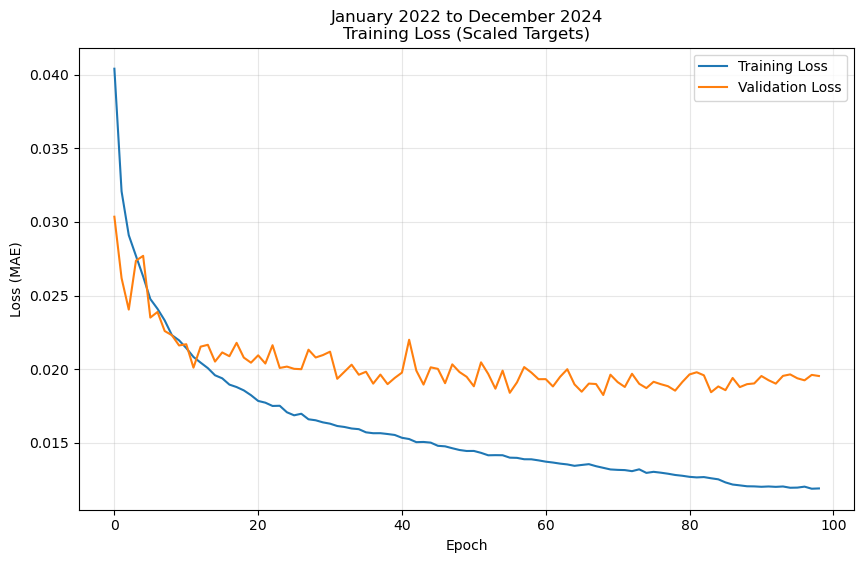


✓ Evaluation completed for January 2022 to December 2024
Results saved to: experiment_output/two_years_pwwb_airnow_hrrr/results


In [ ]:
# Evaluate model
print(f"\nEvaluating model for {EXPERIMENT_NAME}...")
model.eval()
test_loss = 0.0
predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        
        # Calculate loss
        criterion = nn.L1Loss()
        loss = criterion(outputs, batch_y)
        test_loss += loss.item()
        
        # Store predictions and actuals
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(batch_y.cpu().numpy())

test_loss /= len(test_loader)
print(f"Test MAE (scaled): {test_loss:.4f}")

# Convert to numpy arrays
y_pred = np.array(predictions)
y_actual = np.array(actuals)

# Unscale predictions and actuals to get real PM2.5 values (μg/m³)
y_pred_real = y_scaler.inverse_transform(y_pred)
y_actual_real = y_scaler.inverse_transform(y_actual)

# Calculate metrics on real scale
mae_real = mean_absolute_error(y_actual_real, y_pred_real)
rmse_real = np.sqrt(mean_squared_error(y_actual_real, y_pred_real))
r2_real = r2_score(y_actual_real, y_pred_real)

print(f"\nFinal Results for {EXPERIMENT_NAME} (Real PM2.5 Scale):")
print(f"Mean Absolute Error: {mae_real:.4f} μg/m³")
print(f"Root Mean Squared Error: {rmse_real:.4f} μg/m³")
print(f"R² Score: {r2_real:.4f}")

# Also show scaled metrics for comparison
mae_scaled = mean_absolute_error(y_actual, y_pred)
rmse_scaled = np.sqrt(mean_squared_error(y_actual, y_pred))
r2_scaled = r2_score(y_actual, y_pred)

print(f"\nScaled Results (for comparison):")
print(f"Mean Absolute Error: {mae_scaled:.4f}")
print(f"Root Mean Squared Error: {rmse_scaled:.4f}")
print(f"R² Score: {r2_scaled:.4f}")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'{EXPERIMENT_NAME}\nTraining Loss (Scaled Targets)')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

# Save results (save both scaled and real versions)
results_dir = os.path.join(output_dir, "results")
os.makedirs(results_dir, exist_ok=True)

# Save real scale results for analysis
np.save(os.path.join(results_dir, "y_pred_real.npy"), y_pred_real)
np.save(os.path.join(results_dir, "y_actual_real.npy"), y_actual_real)

# Save scaled results for model debugging
np.save(os.path.join(results_dir, "y_pred_scaled.npy"), y_pred)
np.save(os.path.join(results_dir, "y_actual_scaled.npy"), y_actual)

# Save model and scaler
torch.save(model.state_dict(), os.path.join(results_dir, "model.pth"))

torch.save({
    'model_state_dict': model.state_dict(),
    'input_shape': input_shape,
    'output_size': output_size,
    'history': history,
    'experiment_config': {
        'name': EXPERIMENT_NAME,
        'description': EXPERIMENT_DESCRIPTION,
        'id': EXPERIMENT_ID
    }
}, os.path.join(results_dir, "checkpoint.pth"))

# Results dictionary (use real scale values)
experiment_results = {
    'experiment_name': EXPERIMENT_NAME,
    'model': model,
    'history': history,
    'test_loss': test_loss,
    'mae': mae_real,      # Real scale metrics
    'rmse': rmse_real,
    'r2': r2_real,
    'y_pred': y_pred_real,    # Real scale predictions
    'y_actual': y_actual_real,
    'y_scaler': y_scaler      # Include scaler for future use
}

print(f"\n✓ Evaluation completed for {EXPERIMENT_NAME}")
print(f"Results saved to: {results_dir}")

# Detailed Analysis

In [ ]:
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Validation batches: {len(val_loader)}")

Training samples: 11225
Validation samples: 2807
Validation batches: 88


In [ ]:
print(f"\nDetailed analysis for {EXPERIMENT_NAME}:")
print(f"Description: {EXPERIMENT_DESCRIPTION}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Temporal split: {TRAIN_SPLIT*100:.0f}%/{(1-TRAIN_SPLIT)*100:.0f}%")
print(f"Total sensors: {len(airnow_data.air_sens_loc)}")


Detailed analysis for January 2022 to December 2024:
Description: January 2025 fire period with PWWB, Airnow, and HRRR data.
Date range: 2022-12-01-00 to 2024-12-01-00
Temporal split: 80%/20%
Total sensors: 8


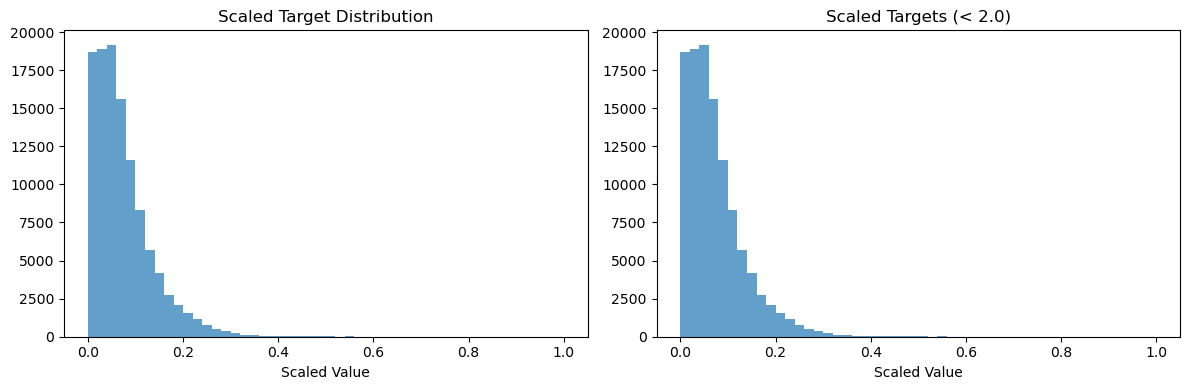

Percentage of targets > 5.0: 0.0%
Percentage of targets > 2.0: 0.0%


In [ ]:
import matplotlib.pyplot as plt

# Check target distribution
Y_flat = Y_train_scaled.flatten()
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(Y_flat, bins=50, alpha=0.7)
plt.title('Scaled Target Distribution')
plt.xlabel('Scaled Value')

plt.subplot(1, 2, 2)
plt.hist(Y_flat[Y_flat < 2], bins=50, alpha=0.7)  # Zoom in on normal range
plt.title('Scaled Targets (< 2.0)')
plt.xlabel('Scaled Value')

plt.tight_layout()
plt.show()

print(f"Percentage of targets > 5.0: {(Y_flat > 5.0).mean()*100:.1f}%")
print(f"Percentage of targets > 2.0: {(Y_flat > 2.0).mean()*100:.1f}%")

In [ ]:
print("Original targets:")
print(f"Y_train range: {Y_train.min():.3f} to {Y_train.max():.3f}")
print("Scaled targets:")  
print(f"Y_train_scaled range: {Y_train_scaled.min():.3f} to {Y_train_scaled.max():.3f}")

Original targets:
Y_train range: 0.000 to 358.900
Scaled targets:
Y_train_scaled range: 0.000 to 1.000



Sensors in January 2022 to December 2024: ['Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 'Compton', 'Long Beach Signal Hill', 'Glendora - Laurel']

1. Plotting prediction comparison...


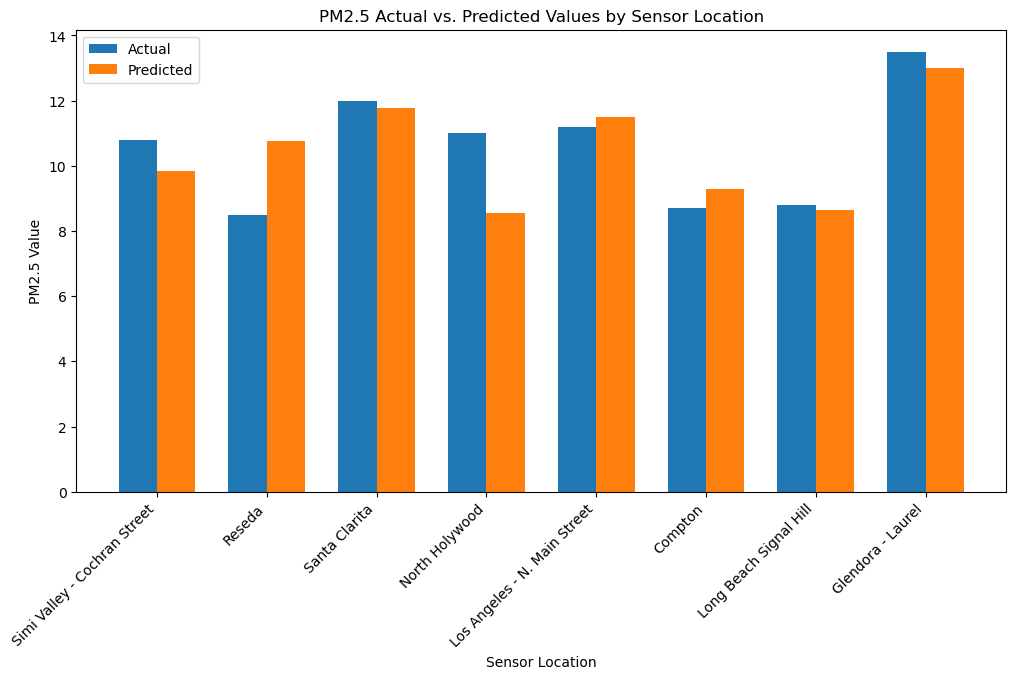


2. Plotting scatter comparison...


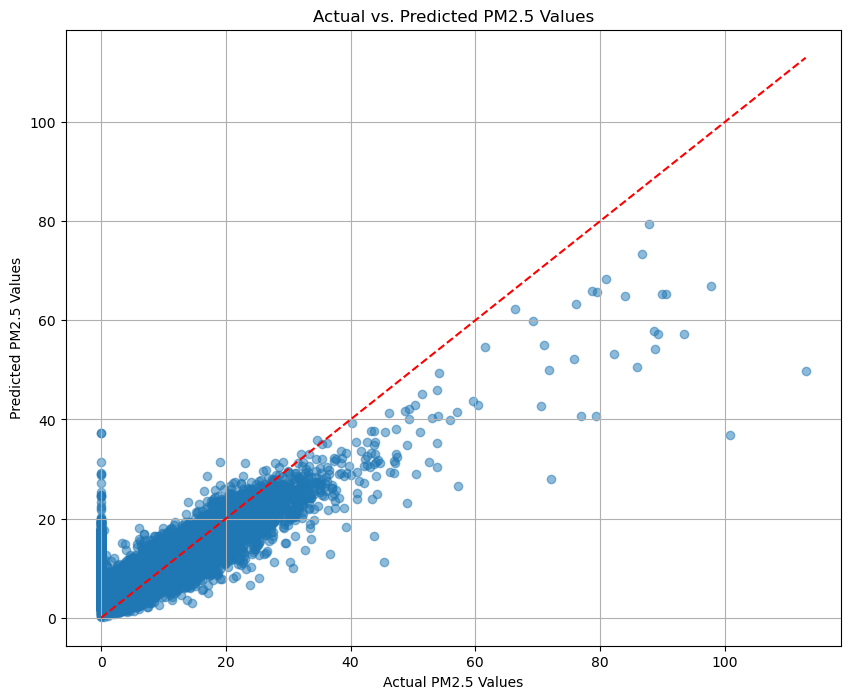


3. Plotting error by sensor...


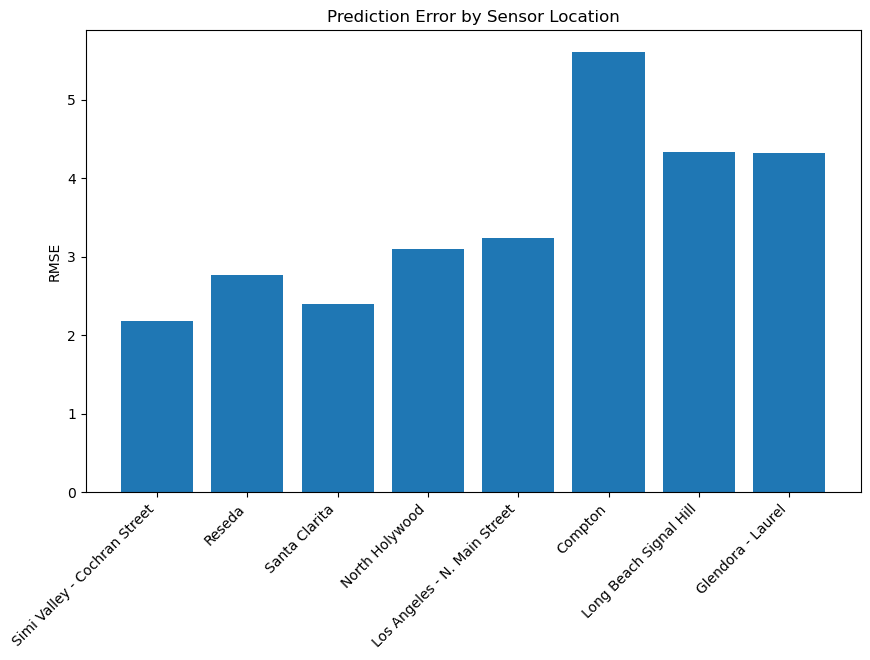


4. Plotting time series comparison...


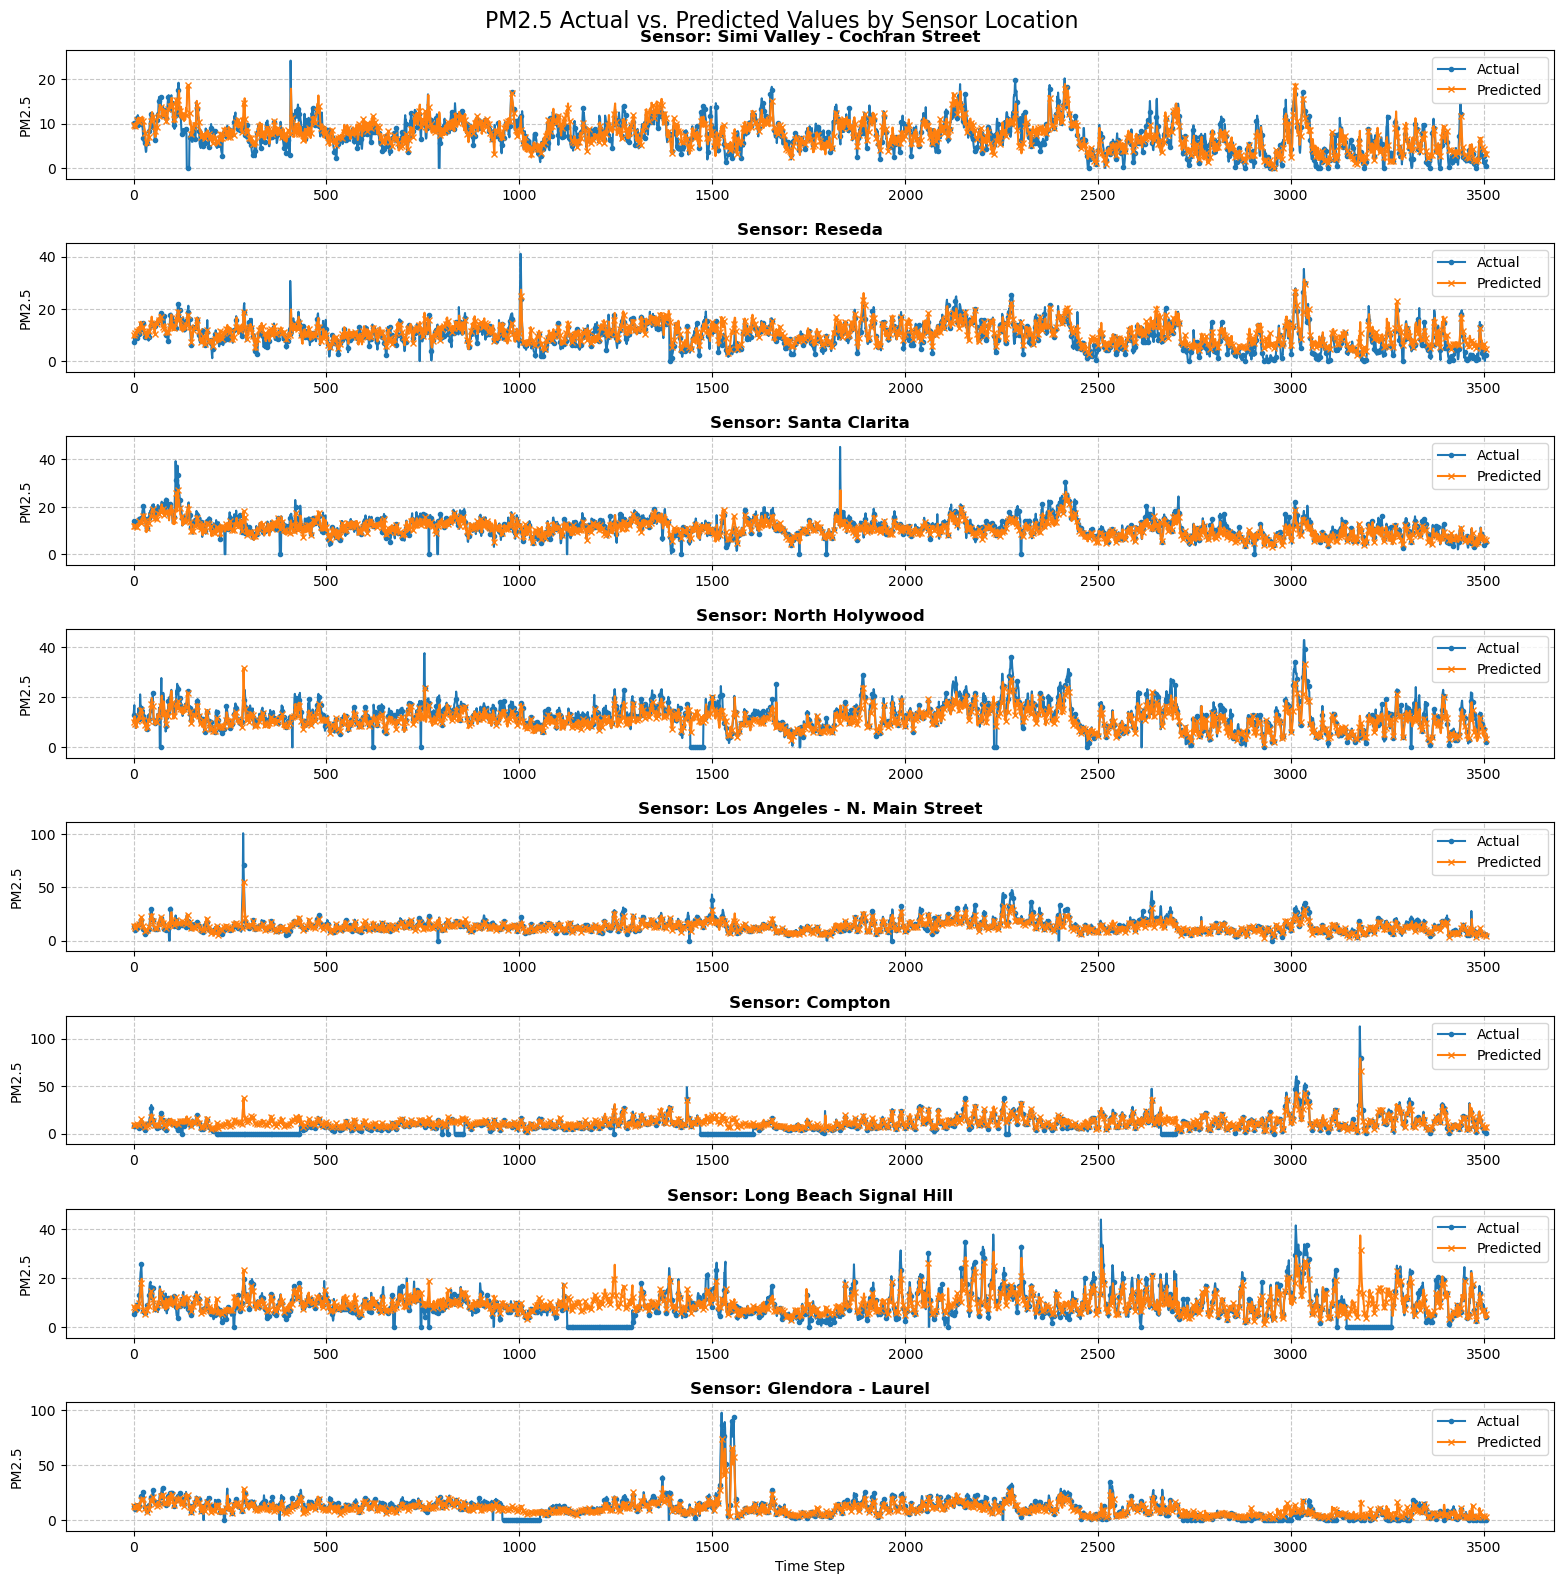


5. Plotting time series with shifted predictions...


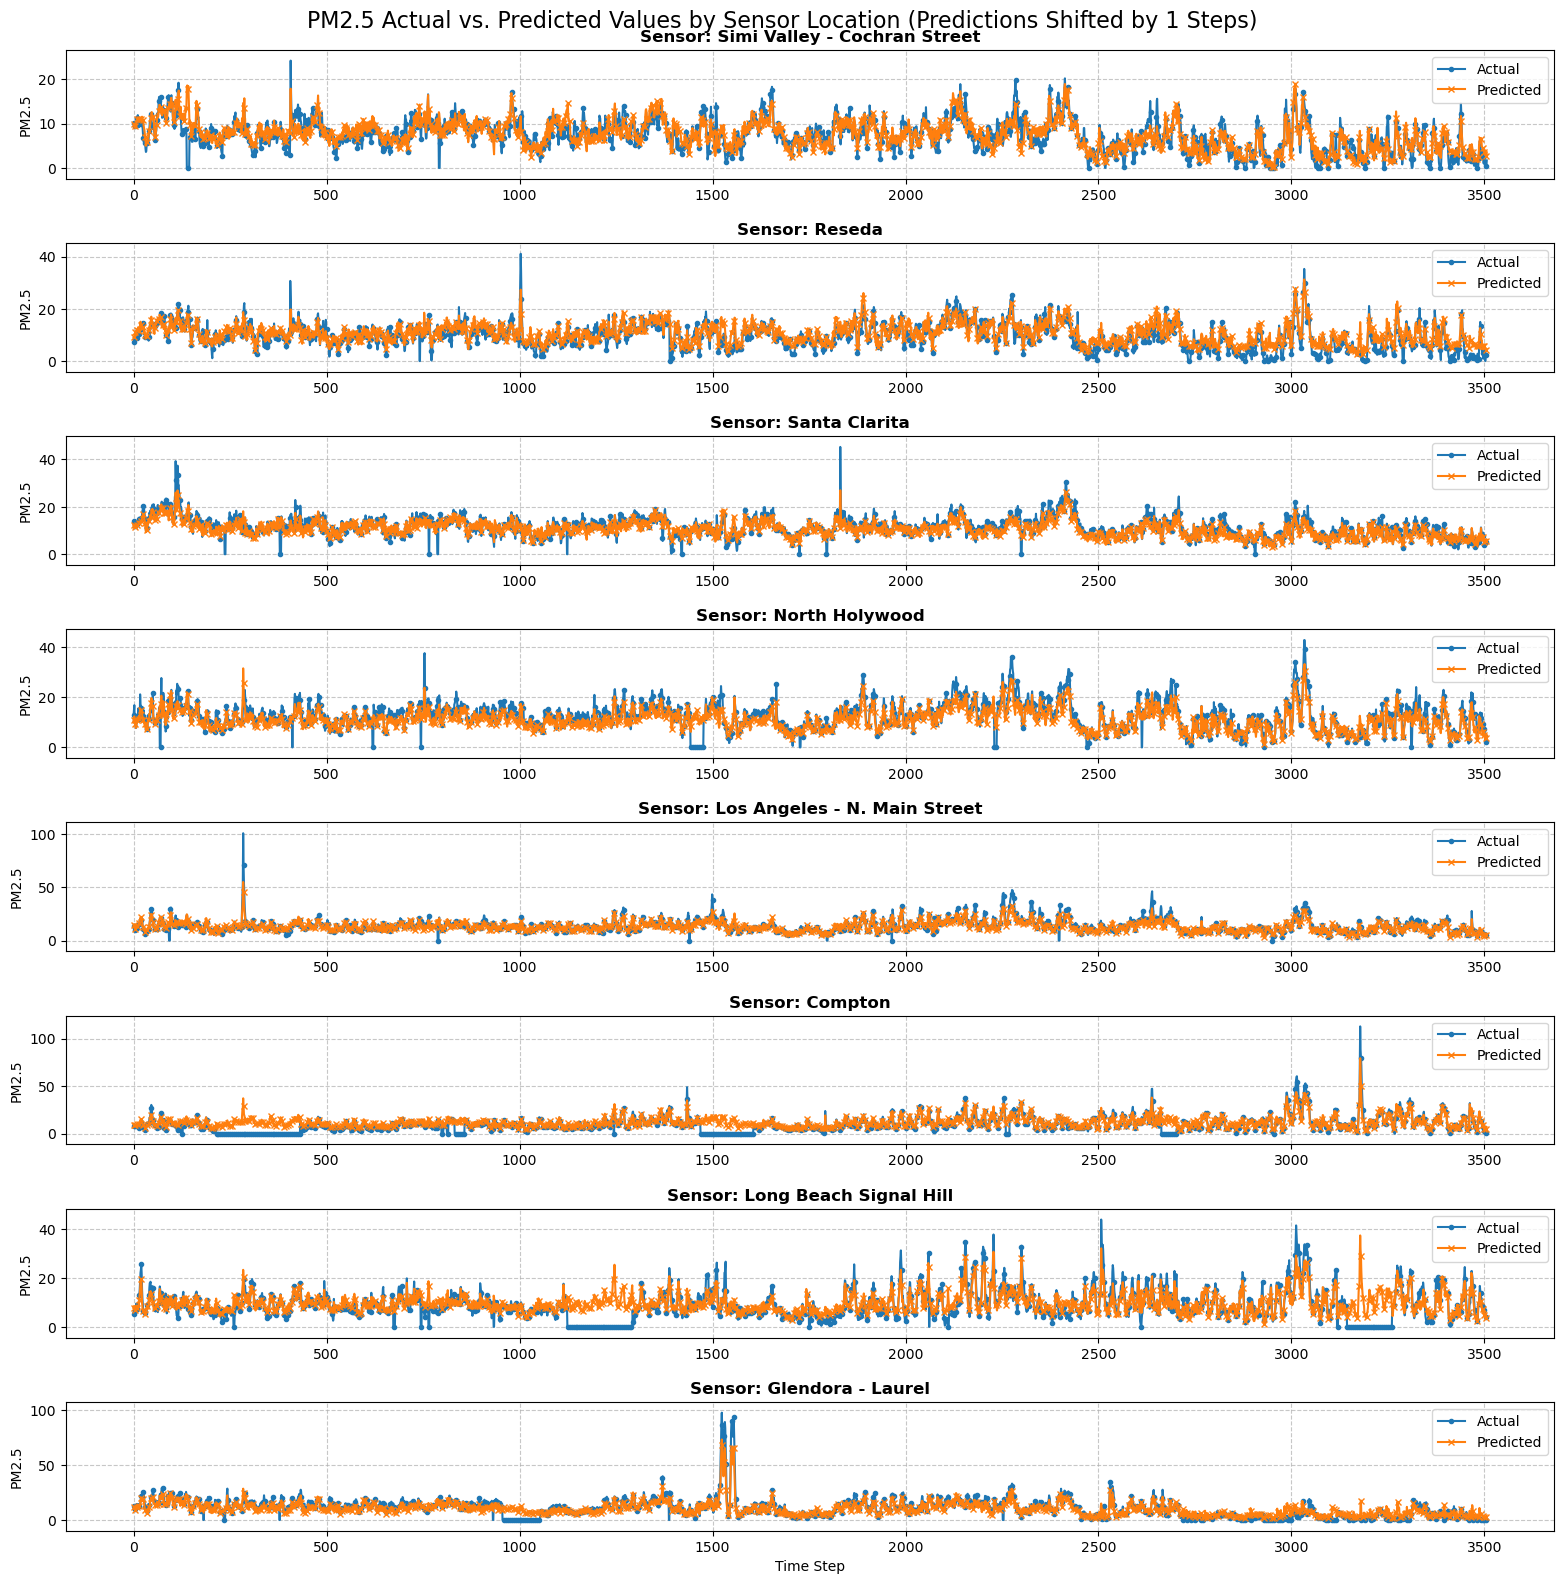


6. Printing detailed metrics...
RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 3.66
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 34.75%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 1.82
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 17.31%

Frame 2 (Hour 2) All Locations - Raw RMSE: 1.77
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 16.74%

Frame 3 (Hour 3) All Locations - Raw RMSE: 2.64
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 25.43%

Frame 4 (Hour 4) All Locations - Raw RMSE: 1.56
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 16.05%

Frame 5 (Hour 5) All Locations - Raw RMSE: 1.50
Frame 5 (Hour 5) All Locations - RMSE Percent Error of Mean: 15.38%

Frame 6 (Hour 6) All Locations - Raw RMSE: 1.41
Frame 6 (Hour 6) All L

In [ ]:
from libs.plotting import (
    plot_prediction_comparison,
    plot_scatter_comparison,
    plot_error_by_sensor,
    plot_time_series_comparison,
    plot_input_frames,
    print_metrics
)

# Get sensor names
if hasattr(airnow_data, 'sensor_names') and airnow_data.sensor_names is not None:
    sensor_names = airnow_data.sensor_names
else:
    sensor_names = list(airnow_data.air_sens_loc.keys())

print(f"\nSensors in {EXPERIMENT_NAME}: {sensor_names}")

print("\n1. Plotting prediction comparison...")
plot_prediction_comparison(y_pred_real, y_actual_real, sensor_names, sample_idx=8)

print("\n2. Plotting scatter comparison...")
plot_scatter_comparison(y_pred_real, y_actual_real)

print("\n3. Plotting error by sensor...")
plot_error_by_sensor(y_pred_real, y_actual_real, sensor_names)

print("\n4. Plotting time series comparison...")
plot_time_series_comparison(y_pred_real, y_actual_real, sensor_names)
    
print("\n5. Plotting time series with shifted predictions...")
plot_time_series_comparison(y_pred_real, y_actual_real, sensor_names, shift_pred=1)

print("\n6. Printing detailed metrics...")
print_metrics(y_pred_real, y_actual_real, sensor_names)